<a href="https://colab.research.google.com/github/WellingtonLandim/wellingtonlandim.github.io/blob/main/Sistema_Recomendacao/Sistema_Recomenacao_Keras_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistema de Recomendação por similaridade de imagem



In [ ]:
!pip install tensorflow==2.15.0
!pip install keras==2.15.0
!pip install tensorflow_hub==0.13.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.0
    Uninstalling wrapt-1.17.0:
      Successfully uninstalled wrapt-1.17.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorboard
    Found existing installation: 

In [ ]:
#Montar o Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importar Bibliotecas necessárias

In [ ]:
import pandas as pd
import os
from tqdm import tqdm
import itertools
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")
from pathlib import Path
tqdm.pandas()
import pickle
import glob
tqdm.pandas()
!pip install -q annoy
import json
from annoy import AnnoyIndex
from scipy import spatial
from IPython.display import Image as dispImage
from PIL import Image
import matplotlib.image as mpimg

TF version: 2.15.0
Hub version: 0.13.0
GPU is NOT AVAILABLE


In [ ]:
#import kagglehub

### Step 1: Data Acquisition

Construir o dataset para armazenar as imagens.

In [ ]:
# downloading raw images from kaggle
#!kaggle datasets download -d sunnykusawa/ecommerce-products-image-dataset

#!unzip ecommerce-products-image-dataset.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: myntradataset/images/5813.jpg  
  inflating: myntradataset/images/58131.jpg  
  inflating: myntradataset/images/58132.jpg  
  inflating: myntradataset/images/58133.jpg  
  inflating: myntradataset/images/58135.jpg  
  inflating: myntradataset/images/58136.jpg  
  inflating: myntradataset/images/58137.jpg  
  inflating: myntradataset/images/58138.jpg  
  inflating: myntradataset/images/58139.jpg  
  inflating: myntradataset/images/5814.jpg  
  inflating: myntradataset/images/58140.jpg  
  inflating: myntradataset/images/58141.jpg  
  inflating: myntradataset/images/58143.jpg  
  inflating: myntradataset/images/58144.jpg  
  inflating: myntradataset/images/58145.jpg  
  inflating: myntradataset/images/58146.jpg  
  inflating: myntradataset/images/58147.jpg  
  inflating: myntradataset/images/58148.jpg  
  inflating: myntradataset/images/58149.jpg  
  inflating: myntradataset/images/5815.jpg  
  inflating: myntradatas

In [ ]:

if not os.path.exists('/content/drive/MyDrive/00 - DIO - Machine Learning/Fashion_data'):
    os.mkdir('/content/drive/MyDrive/00 - DIO - Machine Learning/Fashion_data')
    os.mkdir('/content/drive/MyDrive/00 - DIO - Machine Learning/Fashion_data/categories')



### Step 2: Fine-tuning - para treinamento

Download do modelo de imagem pré-treinado e adiciona duas camadas: a primeira camada será uma camada de vetor de características e a segunda camada será a camada de classificação.
O treinamento se dará apenas nessas duas camadas com dados fornecidos e, após o treinamento, será selecionada a camada de vetor de características como a saída do codificador ajustado.
Após ajustar o modelo, será salvo o extrator de características para uso futuro. Sem que haja necessidade de retreinamento

**Para testes em uma rede já treinada: pular para o step 3**

In [ ]:
MODULE_HANDLE = 'https://tfhub.dev/google/bit/m-r50x3/1'
IMAGE_SIZE = (224, 224)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))
#BATCH_SIZE = 32 #usar 32 se desejar um ajuste mais fino
BATCH_SIZE = 16
N_FEATURES = 256

Using https://tfhub.dev/google/bit/m-r50x3/1 with input size (224, 224)


In [ ]:
data_dir = '/content/drive/MyDrive/00 - DIO - Machine Learning/Fashion_data/categories'

In [ ]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = True
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 16 images belonging to 2 classes.
Found 64 images belonging to 2 classes.


In [ ]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=False),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(N_FEATURES,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/bit/m-r50x3/1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 6144)              211174080 
                                                                 
 dropout (Dropout)           (None, 6144)              0         
                                                                 
 dense (Dense)               (None, 256)               1573120   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 212747714 (811.57 MB)
Trainable params: 1573634 (6.00 MB)
Non-trainable params: 211174080 (805.57 MB)
_____________

In [ ]:
# Define optimiser and loss
lr = 0.003 * BATCH_SIZE / 512
SCHEDULE_LENGTH = 500
SCHEDULE_BOUNDARIES = [200, 300, 400]

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES,
                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001])
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [ ]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size

In [ ]:
# Ensure that the `train_generator` is correctly initialized and has samples.
print(f"Number of samples in train_generator: {train_generator.samples}")
print(f"Batch size of train_generator: {train_generator.batch_size}")
print(f"Number of batches in train_generator: {train_generator.batch_size}")

Number of samples in train_generator: 64
Batch size of train_generator: 16
Number of batches in train_generator: 16


In [ ]:

hist = model.fit(
    train_generator,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Epoch 1/5
4/4 [==============================] - 211s 51s/step - loss: 1.9641 - accuracy: 0.5469 - val_loss: 0.7833 - val_accuracy: 0.7500
Epoch 2/5
4/4 [==============================] - 183s 50s/step - loss: 0.4706 - accuracy: 0.8750 - val_loss: 0.2068 - val_accuracy: 0.9375
Epoch 3/5
4/4 [==============================] - 172s 45s/step - loss: 0.1556 - accuracy: 0.9375 - val_loss: 0.0513 - val_accuracy: 1.0000
Epoch 4/5
4/4 [==============================] - 168s 45s/step - loss: 0.0558 - accuracy: 1.0000 - val_loss: 0.0496 - val_accuracy: 1.0000
Epoch 5/5
4/4 [==============================] - 169s 45s/step - loss: 0.0826 - accuracy: 0.9844 - val_loss: 0.0495 - val_accuracy: 1.0000


In [ ]:
# Save the training history to a file
with open('/content/drive/MyDrive/00 - DIO - Machine Learning/Treinamento_Yolo_epocas/training_history.pkl', 'wb') as file:
    pickle.dump(hist, file)

In [ ]:
# Load the training history from the file
with open('/content/drive/MyDrive/00 - DIO - Machine Learning/Treinamento_Yolo_epocas/training_history.pkl', 'rb') as file:
    hist2 = pickle.load(file)

# Now you can work with the 'hist' dictionary
print(hist2.keys()) # Check available keys


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


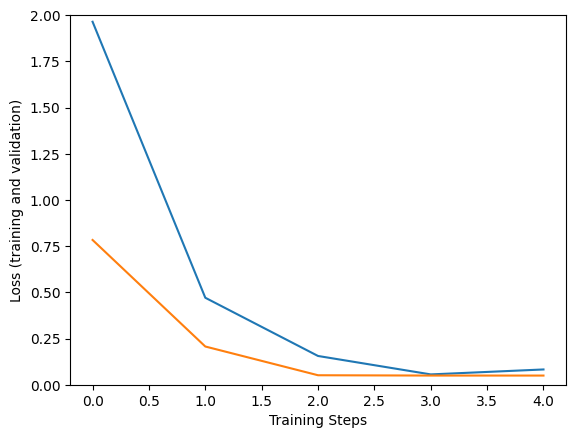

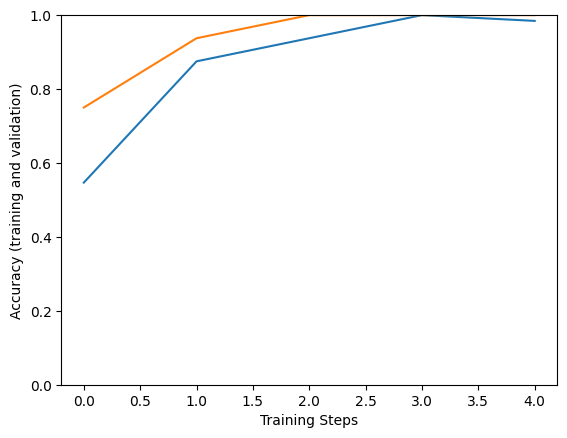

In [ ]:
#hide
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist2["loss"])
plt.plot(hist2["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist2["accuracy"])
plt.plot(hist2["val_accuracy"])

In [ ]:
if not os.path.exists('/content/drive/MyDrive/00 - DIO - Machine Learning/Treinamento_Yolo_epocas/ImgSim/'):
    os.mkdir('/content/drive/MyDrive/00 - DIO - Machine Learning/Treinamento_Yolo_epocas/ImgSim/')

feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-3].output)
feature_extractor.save('/content/drive/MyDrive/00 - DIO - Machine Learning/Treinamento_Yolo_epocas/ImgSim/bit_feature_extractor', save_format='tf')

saved_model_path = '/content/drive/MyDrive/00 - DIO - Machine Learning/Treinamento_Yolo_epocas/ImgSim/bit_model'
tf.saved_model.save(model, saved_model_path)

### Step 3: Vetorização
Agora, usaremos o codificador (preparado na etapa 2) para codificar as imagens (preparadas na etapa 1). Salvaremos o vetor de características de cada imagem como um array em um diretório. Após o processamento, salvaremos essas infomrações para uso futuro.

In [ ]:
img_paths = []
for path in Path('/content/drive/MyDrive/00 - DIO - Machine Learning/Fashion_data/categories').rglob('*.jpg'):
  img_paths.append(path)
np.random.shuffle(img_paths)

In [ ]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.resize_with_pad(img, 224, 224)
  img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  return img

In [ ]:
#hide-output
TRANSFER_LEARNING_FLAG = 1
if TRANSFER_LEARNING_FLAG:
  module = tf.keras.models.load_model('/content/drive/MyDrive/00 - DIO - Machine Learning/Treinamento_Yolo_epocas/ImgSim/bit_feature_extractor')
else:
  module_handle = "https://tfhub.dev/google/bit/s-r50x3/ilsvrc2012_classification/1"
  module = hub.load(module_handle)

In [ ]:
imgvec_path = '/content/img_vectors/'
Path(imgvec_path).mkdir(parents=True, exist_ok=True)

In [ ]:
for filename in tqdm(img_paths[:5000]):
    img = load_img(str(filename))
    features = module(img)
    feature_set = np.squeeze(features)
    outfile_name = os.path.basename(filename).split('.')[0] + ".npz"
    out_path_file = os.path.join(imgvec_path, outfile_name)
    np.savetxt(out_path_file, feature_set, delimiter=',')

100%|██████████| 80/80 [04:48<00:00,  3.61s/it]


### Step 4: Metadata and Indexing


Atribuiremos um ID único a cada imagem e criaremos dicionários para localizar as informações dessa imagem:


1.   Dicionário de ID da imagem para o nome da imagem,
2.   Dicionário de ID da imagem para o vetor de características da imagem e
3.  (opcional) Dicionário de ID da imagem para o ID do produto nos metadados.

Também criaremos uma indexação do ID da imagem para o vetor de características da imagem.
Em seguida, salvaremos esses dicionários e o objeto de indexação para uso futuro.

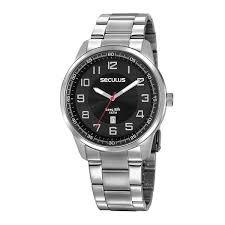

In [ ]:
test_img = '/content/drive/MyDrive/00 - DIO - Machine Learning/Fashion_data/categories/relogio/1004.jpg'
dispImage(test_img)

In [ ]:
#hide
root_path = '/content/drive/MyDrive/00 - DIO - Machine Learning/Treinamento_Yolo_epocas/ImgSim'

In [ ]:
#hide-output
styles = pd.read_csv('/content/drive/MyDrive/00 - DIO - Machine Learning/Styles.csv', sep=';', usecols=range(7), dtype=str)
#styles['id'] = styles['id'].astype('str')
styles.to_csv(root_path+'/styles.csv', index=False)

In [ ]:
styles.head()


,id,gender,masterCategory,subCategory,articleType,baseColour,productDisplayName
0,001,Woman,ursinho,Teddy Bear,Urso,Marrom,Ursinho de pelucia
1,002,Woman,ursinho,Teddy Bear,Urso,Marrom,Ursinho de pelucia
2,003,Woman,ursinho,Teddy Bear,Urso,Marrom,Ursinho de pelucia
3,004,Woman,ursinho,Teddy Bear,Urso,Marrom,Ursinho de pelucia
4,005,Woman,ursinho,Teddy Bear,Urso,Marrom,Ursinho de pelucia


In [ ]:
def match_id(fname):
  return styles.index[styles.id==fname].values[0]

In [ ]:
def match_id2(fname):
    matches = styles.index[styles.id == fname].values
    if len(matches) == 0:
        raise ValueError(f"ID {fname} não encontrado no dataframe styles.")
    return matches[0]

In [ ]:
# Defining data structures as empty dict
file_index_to_file_name = {}
file_index_to_file_vector = {}
file_index_to_product_id = {}

# Configuring annoy parameters
dims = 256
n_nearest_neighbors = 20
trees = 10000

# Reads all file names which stores feature vectors
allfiles = glob.glob('/content/img_vectors/*.npz')

t = AnnoyIndex(dims, metric='angular')
t

In [ ]:
for findex, fname in tqdm(enumerate(allfiles)):
    file_vector = np.loadtxt(fname)
    file_name = os.path.basename(fname).split('.')[0]
    file_index_to_file_name[findex] = file_name
    file_index_to_file_vector[findex] = file_vector
    try:
        file_index_to_product_id[findex] = match_id(file_name)
    except IndexError:
        print(f"Erro ao mapear ID para o arquivo: {file_name} (índice: {findex})")

80it [00:00, 360.40it/s]

Erro ao mapear ID para o arquivo: 000 (índice: 62)


In [ ]:
for findex, fname in tqdm(enumerate(allfiles)):
  file_vector = np.loadtxt(fname)
  file_name = os.path.basename(fname).split('.')[0]
  file_index_to_file_name[findex] = file_name
  file_index_to_file_vector[findex] = file_vector
  try:
    file_index_to_product_id[findex] = match_id(file_name)
  except IndexError:
    pass
  t.add_item(findex, file_vector)

80it [00:00, 650.57it/s]


In [ ]:
#hide-output
t.build(trees)
t.save('t.ann')

True

In [ ]:
#hide
file_path = '/content/drive/MyDrive/00 - DIO - Machine Learning/Treinamento_Yolo_epocas/ImgSim'

In [ ]:
t.save(file_path+'indexer.ann')
pickle.dump(file_index_to_file_name, open(file_path+"file_index_to_file_name.p", "wb"))
pickle.dump(file_index_to_file_vector, open(file_path+"file_index_to_file_vector.p", "wb"))
pickle.dump(file_index_to_product_id, open(file_path+"file_index_to_product_id.p", "wb"))

## Step 5: Testes

Carregar a imagem para encontrar as mais parecidas

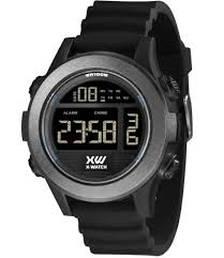

In [ ]:

test_img = '/content/drive/MyDrive/00 - DIO - Machine Learning/Fashion_data/categories/relogio/1018.jpg'
topK = 4

test_vec = np.squeeze(module(load_img(test_img)))

basewidth = 224
img = Image.open(test_img)
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((basewidth,hsize), Image.Resampling.LANCZOS)
img

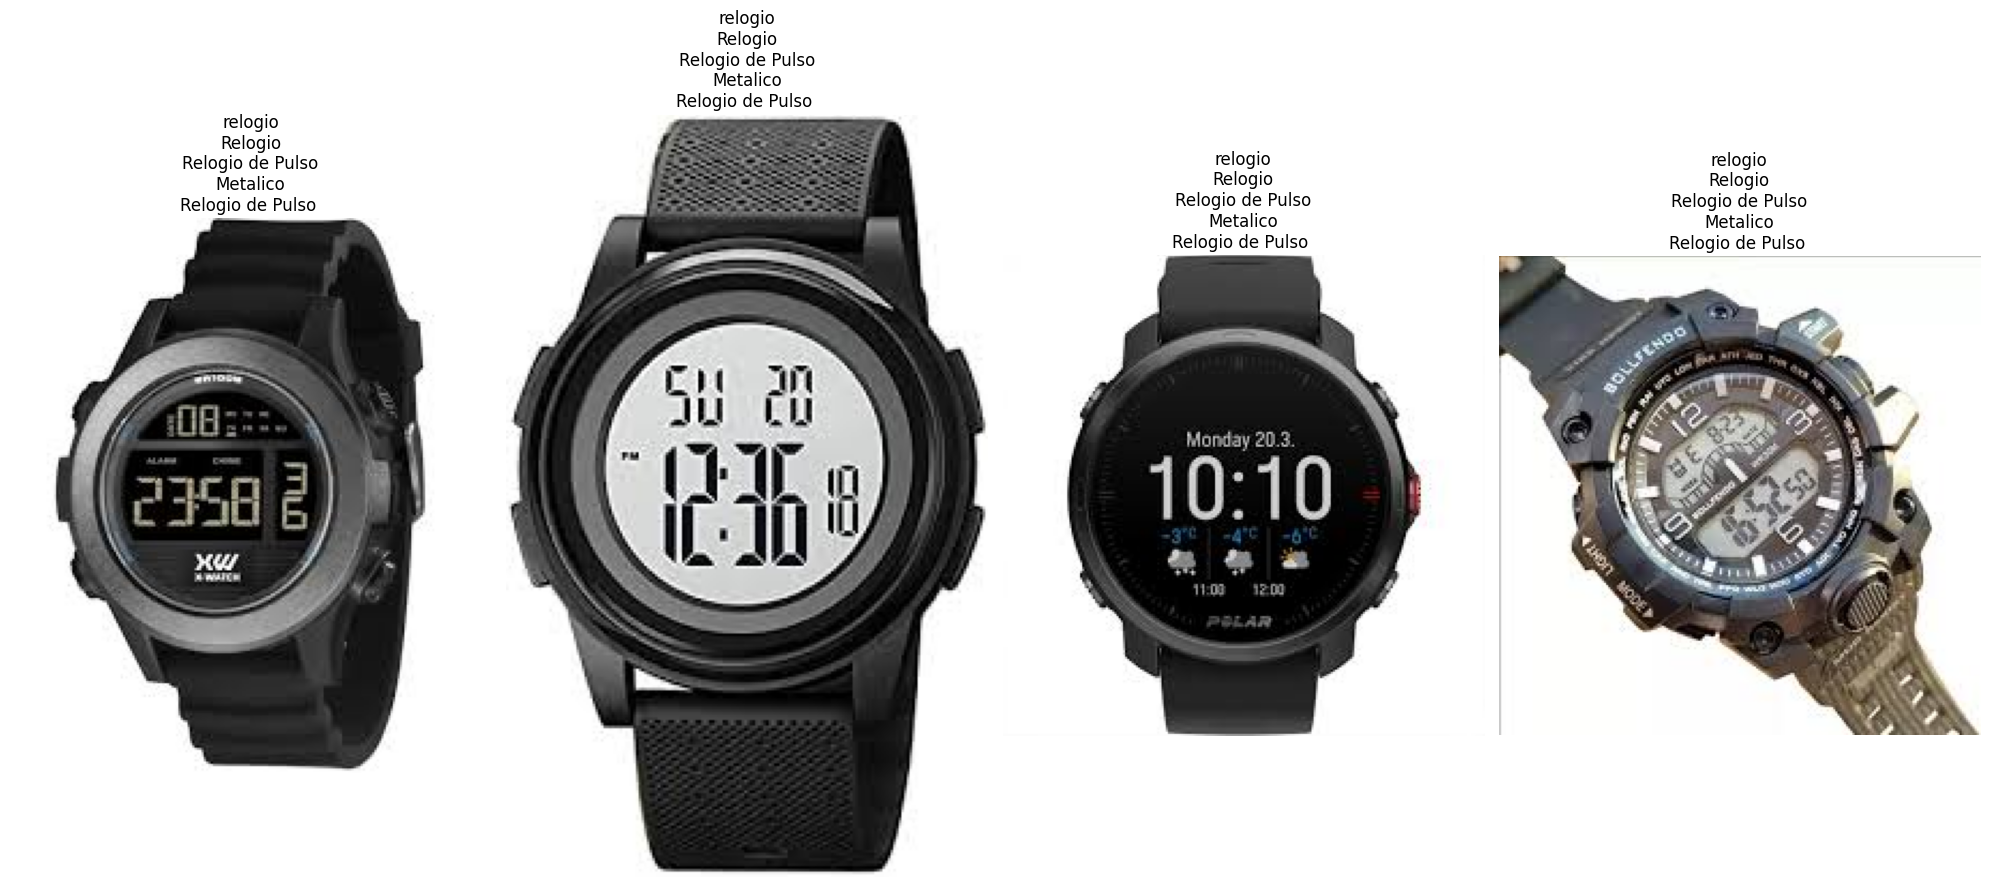

In [ ]:
path_dict = {}
for path in Path('/content/drive/MyDrive/00 - DIO - Machine Learning/Fashion_data/categories').rglob('*.jpg'):
  path_dict[path.name] = path

nns = t.get_nns_by_vector(test_vec, n=topK)
plt.figure(figsize=(20, 10))
for i in range(topK):
  x = file_index_to_file_name[nns[i]]
  x = path_dict[x+'.jpg']
  # Check if the key exists before accessing the dictionary
  if nns[i] in file_index_to_product_id:
    y = file_index_to_product_id[nns[i]]
    title = '\n'.join([str(j) for j in list(styles.loc[y].values[-5:])])
  else:
    # Handle the case where the key is not found
    print(f"Warning: Product ID not found for file index {nns[i]}. Skipping.")
    continue # Skip to the next iteration

  plt.subplot(1, topK, i+1)
  plt.title(title)
  plt.imshow(mpimg.imread(x))
  plt.axis('off')
plt.tight_layout()